## Import Packages

In [3]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score

from datetime import datetime, timedelta

from sklearn.metrics import pairwise

from statistics import mean

from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_classification

## Data Processing

In [4]:
random.seed(3888)

In [5]:
df = pd.read_csv("data/data.txt")
df = df.drop(columns='Unnamed: 0')

In [6]:
df_without_covid = df.drop(columns=['new_cases_per_million', 
                                    'new_cases_smoothed_per_million', 
                                    'stringency_index', 
                                    'positive_rate', 
                                    'human_development_index', 
                                    'international_travel_controls',
                                    'cost_living_index',
                                    'date'])

In [7]:
df_without_covid = df_without_covid.drop_duplicates()
df_without_covid = df_without_covid.reset_index()
df_without_covid = df_without_covid.drop(columns=['index'])

df_without_covid

,iso_code,location,continent,tourist_service_index
0,ALB,Albania,Europe,4.01
1,DZA,Algeria,Africa,1.84
2,ARG,Argentina,South America,4.53
3,ARM,Armenia,Asia,4.33
4,AUS,Australia,Oceania,6.06
...,...,...,...,...
111,VEN,Venezuela,South America,2.96
112,VNM,Vietnam,Asia,2.85
113,YEM,Yemen,Asia,1.87
114,ZMB,Zambia,Africa,2.52


In [8]:
covid = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv")

In [9]:
covid_colnames = ['iso_code', 
                  'new_cases_smoothed_per_million',
                  'date'
                 ]

covid_needed_cols = covid[covid_colnames]
covid_needed_cols['date'] = pd.to_datetime(covid_needed_cols['date'], format='%Y-%m-%d')

covid_needed_cols = covid_needed_cols[covid_needed_cols['date'] >= datetime.now() - timedelta(days = 90)]

covid_merged = pd.merge(covid_needed_cols, df_without_covid, on="iso_code")
covid_merged

<ipython-input-9-be24d8516387>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_needed_cols['date'] = pd.to_datetime(covid_needed_cols['date'], format='%Y-%m-%d')


,iso_code,new_cases_smoothed_per_million,date,location,continent,tourist_service_index
0,ALB,508.440,2022-02-02,Albania,Europe,4.01
1,ALB,430.769,2022-02-03,Albania,Europe,4.01
2,ALB,449.814,2022-02-04,Albania,Europe,4.01
3,ALB,449.814,2022-02-05,Albania,Europe,4.01
4,ALB,441.709,2022-02-06,Albania,Europe,4.01
...,...,...,...,...,...,...
10319,ZWE,3.720,2022-04-27,Zimbabwe,Africa,2.95
10320,ZWE,3.796,2022-04-28,Zimbabwe,Africa,2.95
10321,ZWE,3.351,2022-04-29,Zimbabwe,Africa,2.95
10322,ZWE,3.322,2022-04-30,Zimbabwe,Africa,2.95


In [10]:
medians = covid_merged.groupby(["iso_code"]).median()
medians = medians.fillna(covid_merged.median())
medians

<ipython-input-10-7216510ec984>:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  medians = medians.fillna(covid_merged.median())


,new_cases_smoothed_per_million,tourist_service_index
iso_code,,
ALB,21.929,4.01
ARE,34.488,5.63
ARG,109.103,4.53
ARM,19.830,4.33
AUS,1531.688,6.06
...,...,...
VNM,579.879,2.85
YEM,0.042,1.87
ZAF,26.441,4.30


In [11]:
iso_code = medians.index
scaler = MinMaxScaler()
medians_scaled = scaler.fit_transform(medians)
medians_scaled = pd.DataFrame(medians_scaled, 
                              columns = ["new_cases_smoothed_per_million", "tourist_service_index"], 
                              index = iso_code)
medians_scaled

,new_cases_smoothed_per_million,tourist_service_index
iso_code,,
ALB,0.005560,0.458753
ARE,0.008744,0.784708
ARG,0.027662,0.563380
ARM,0.005028,0.523139
AUS,0.388344,0.871227
...,...,...
VNM,0.147022,0.225352
YEM,0.000011,0.028169
ZAF,0.006704,0.517103


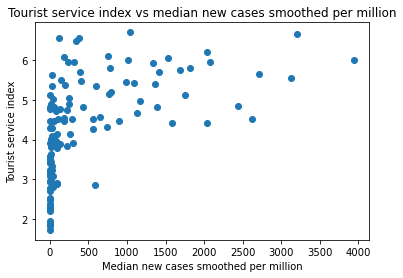

In [12]:
fig, ax = plt.subplots()

scatter = ax.scatter("new_cases_smoothed_per_million", 
                     "tourist_service_index", 
                     data = medians)


plt.title("Tourist service index vs median new cases smoothed per million")
plt.xlabel("Median new cases smoothed per million")
plt.ylabel("Tourist service index")

plt.show()

## Nearest Neighbours

### All metrics

In [ ]:
def iso_code_to_loc(iso_code):
    return iso_location[iso_location["iso_code"] == iso_code]["location"].iloc[0]
num_neighbours = 5
dist_metrics = ['euclidean', 'manhattan', 'chebyshev', 'cosine', 'cityblock', 'l1',
                'l2', 'braycurtis','canberra', 'correlation','dice', 'hamming',
                'jaccard', 'kulsinski', 'minkowski','rogerstanimoto', 'russellrao',
                 'sokalmichener','sokalsneath', 'sqeuclidean','yule']
location_neighbours = {}

for metric in dist_metrics:
    nbrs = NearestNeighbors(metric = metric, 
                            n_neighbors = num_neighbours + 1, 
                            algorithm='auto').fit(medians_scaled)
    
    nbr_indices = list(list(x) for x in nbrs.kneighbors(medians_scaled)[1])
    
    iso_location = df[["iso_code", "location"]].drop_duplicates()

    for i in range(len(nbr_indices)):
        current_iso_code = list(medians_scaled.index)[i]
        current_location = iso_code_to_loc(current_iso_code)

        neighbours = []
        for j in range(1, num_neighbours + 1):
            iso_code = medians_scaled.index[nbr_indices[i][j]]
            neighbours.append(iso_code_to_loc(iso_code))

        if not current_location in location_neighbours:
            location_neighbours[current_location] = {metric: neighbours}
        else:
            location_neighbours[current_location][metric] = neighbours
location_neighbours_df = pd.DataFrame(location_neighbours).transpose()
location_neighbours_df

In [20]:
#removed seuclidean and mahalanobis

In [74]:
prop_sim = []

for location in location_neighbours.keys():
    ind_pairs = [[0, 1], [0, 2], [1, 2]]
    
    for pair in ind_pairs:
        loc_intersect = set(location_neighbours[location][dist_metrics[0]]).intersection(location_neighbours[location][dist_metrics[1]])
        prop_sim.append(len(loc_intersect)/num_neighbours)
        
mean(prop_sim)

0.8844827586206897

In [69]:
def top_5(country):
    d = {}
    lists = location_neighbours_df.loc[country].tolist()
    for ls in lists:
        for c in ls:
            if c in d:
                d[c] += 1
            else:
                d[c] = 1
    top = []
    for k,v in sorted(d.items(), key=lambda p:p[1], reverse=True)[:5]:
        top.append(k)
    return top

In [73]:
#location_neighbours_df["mode"]
locations = location_neighbours_df.index.tolist()
top_5_neighbours = {}
for location in locations:
    top_5_neighbours[location] = top_5(location)
top_5_neighbours_df = pd.DataFrame(top_5_neighbours).transpose()
top_5_neighbours_df

,0,1,2,3,4
Albania,Oman,Ecuador,Lebanon,Morocco,Kuwait
United Arab Emirates,Peru,Montenegro,Costa Rica,Japan,Cameroon
Argentina,Suriname,Romania,Brazil,Myanmar,Cameroon
Armenia,South Africa,Ukraine,Myanmar,Suriname,Cameroon
Australia,France,Luxembourg,Greece,New Zealand,Cameroon
...,...,...,...,...,...
Vietnam,Mongolia,Moldova,Iran,Cameroon,Bangladesh
Yemen,Algeria,Bangladesh,Cameroon,Nepal,Ethiopia
South Africa,Armenia,Ukraine,Myanmar,Suriname,Cameroon
Zambia,Pakistan,Nigeria,Tanzania,Ghana,Rwanda
